In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

In [2]:
%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

In [3]:
df = pd.read_csv("D:\dataset\CIC-IDS-2017\MachineLearningCVE\combISCX.csv")

In [4]:
df["Flow Bytes/s"] = df["Flow Bytes/s"].fillna(df["Flow Bytes/s"].mean())

In [5]:
df["Flow Bytes/s"].isnull().sum()

0

In [6]:
df.shape

(2830743, 79)

In [7]:
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,22,166,1,1,0,0,0,0,0.0,0.0,...,32,0.000,0.000,0,0,0.0,0.000,0,0,BENIGN
1,60148,83,1,2,0,0,0,0,0.0,0.0,...,32,0.000,0.000,0,0,0.0,0.000,0,0,BENIGN
2,123,99947,1,1,48,48,48,48,48.0,0.0,...,40,0.000,0.000,0,0,0.0,0.000,0,0,BENIGN
3,123,37017,1,1,48,48,48,48,48.0,0.0,...,32,0.000,0.000,0,0,0.0,0.000,0,0,BENIGN
4,0,111161336,147,0,0,0,0,0,0.0,0.0,...,0,1753752.625,2123197.578,4822992,95,9463032.7,2657727.996,13600000,5700287,BENIGN


In [8]:
df.isnull().values.any()

False

In [9]:
len(df.columns)

79

C:\Users\gnssl\AppData\Local\Temp\ipykernel_6024\254454083.py:20: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
C:\Users\gnssl\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


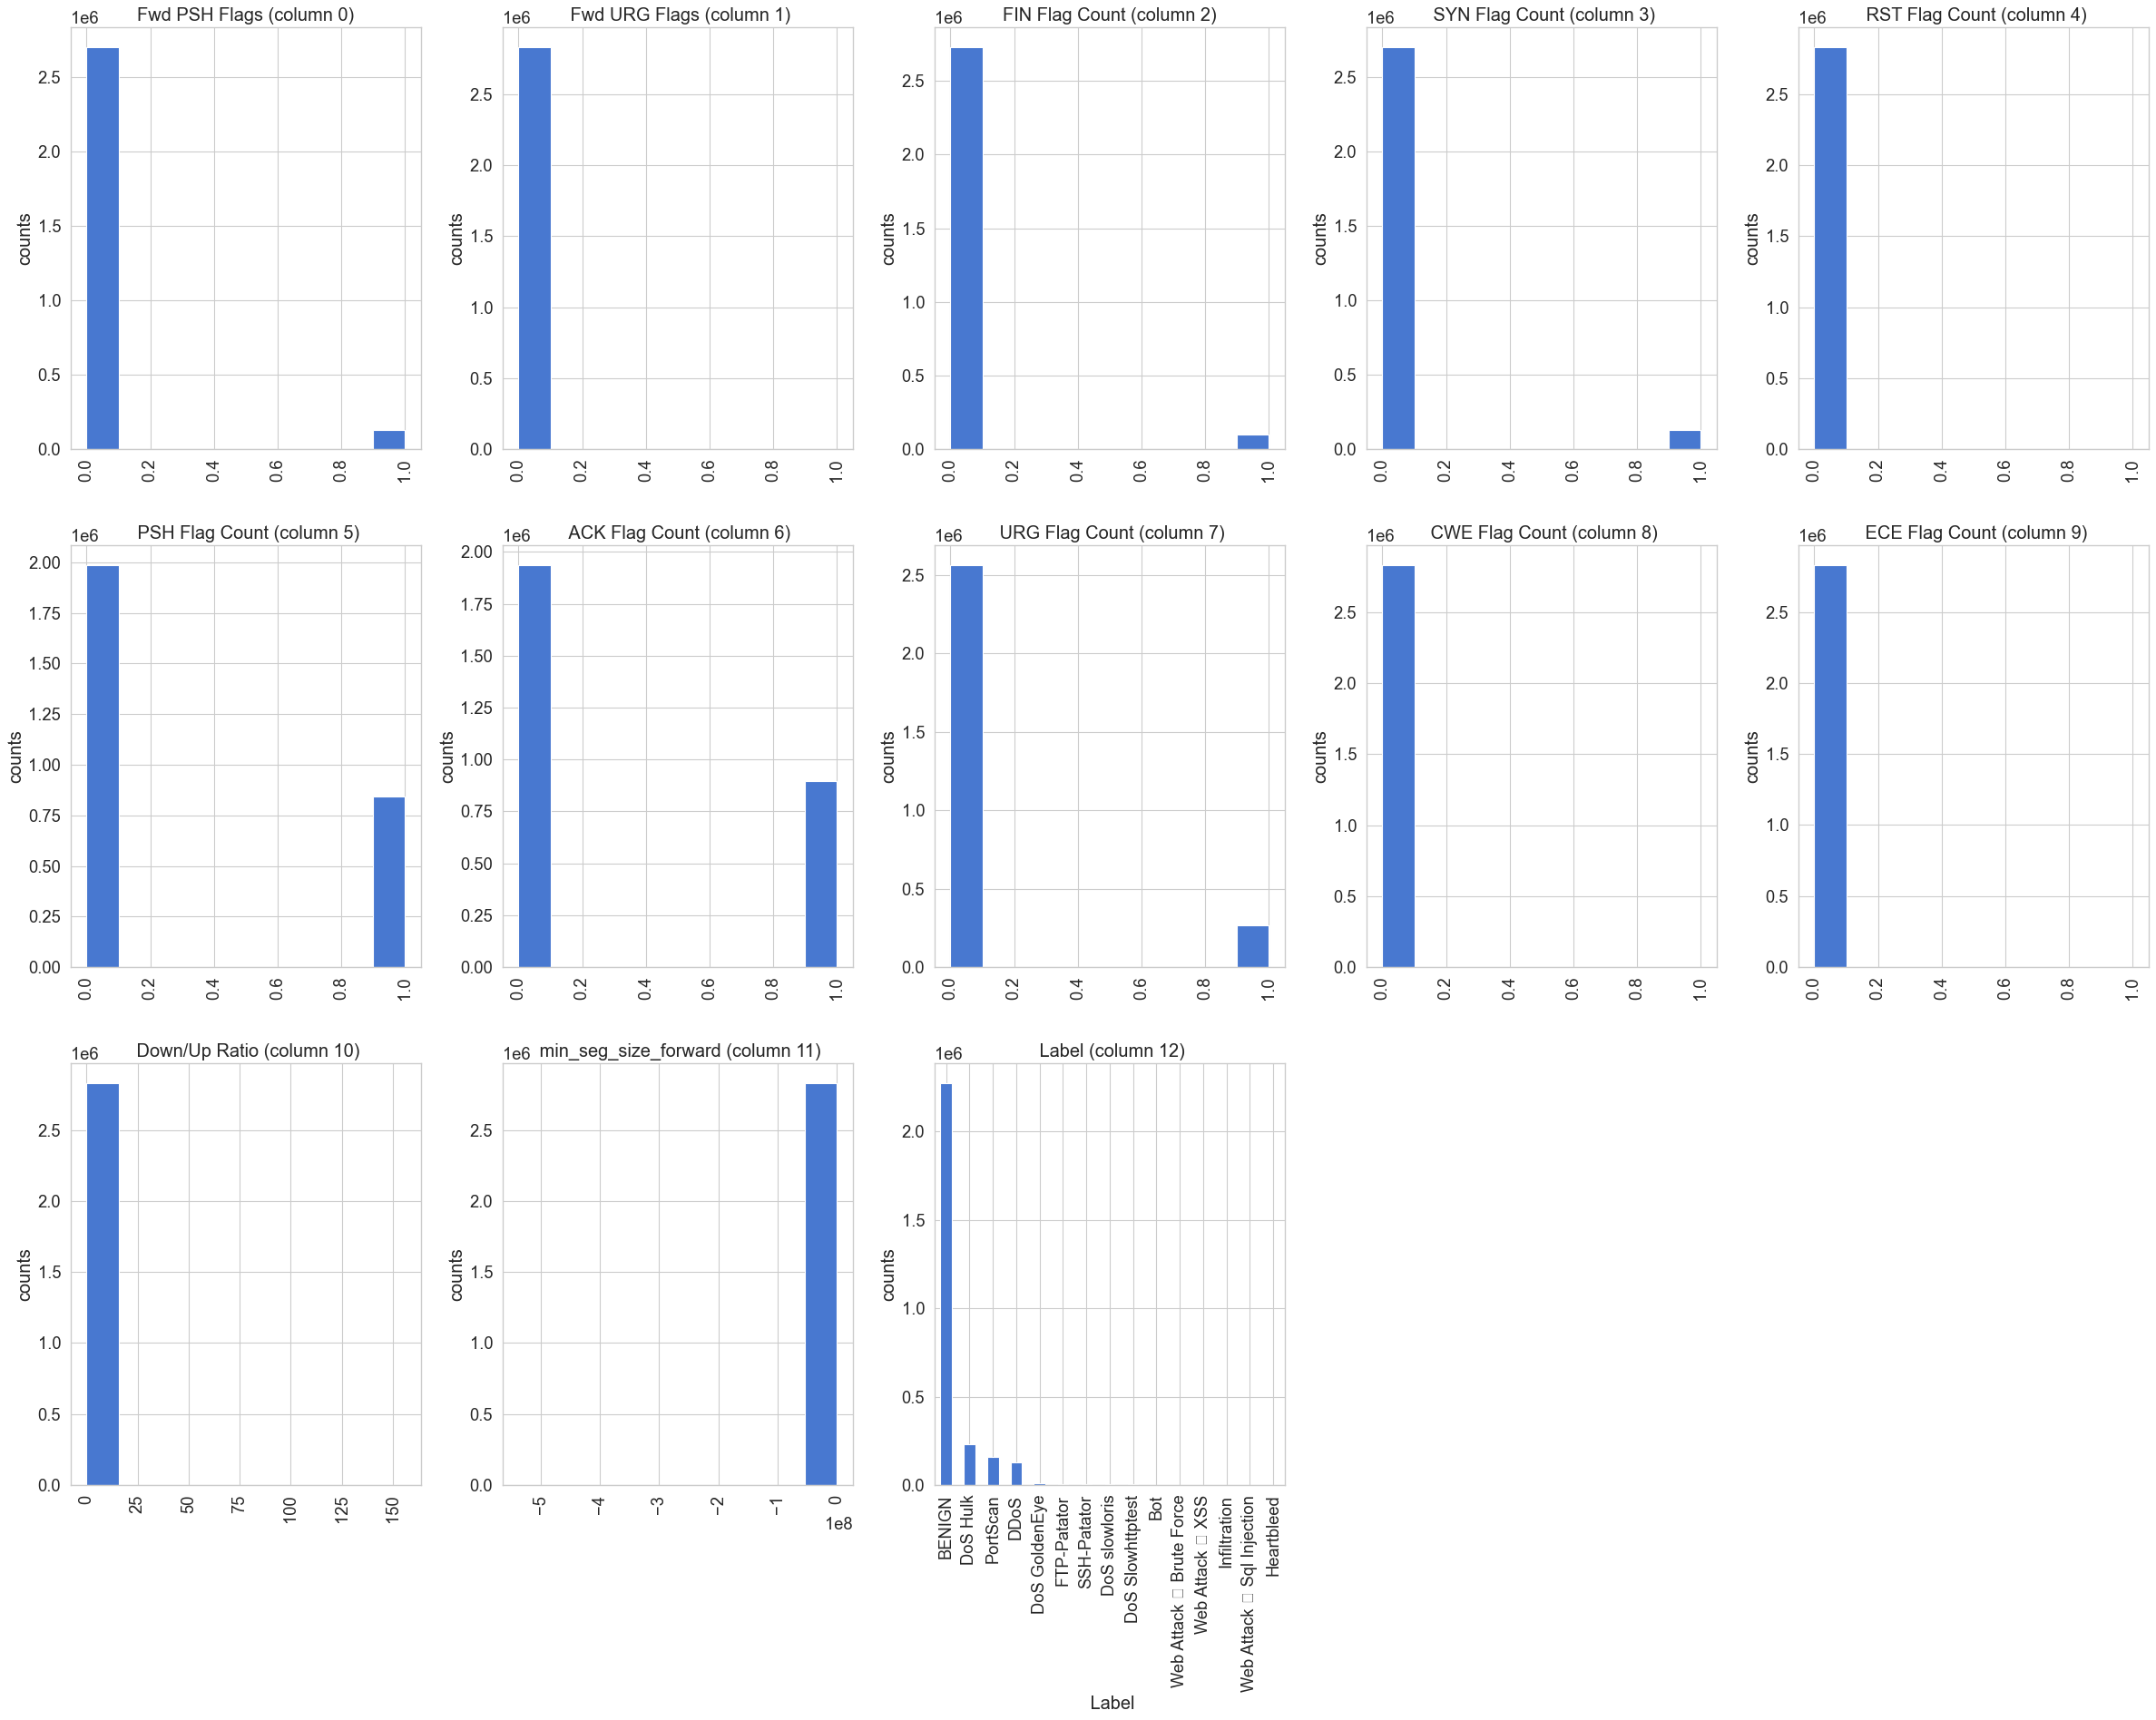

In [10]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = int((nCol + nGraphPerRow - 1) / nGraphPerRow)
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()
    
    
plotPerColumnDistribution(df, 79, 5)

In [11]:
def find_outliers(df):
    outliers_columns = []
    for column in df.columns:
        if df[column].dtype != 'object':
            std = df[column].std()
            if std > 0:
                z_score = (df[column] - df[column].mean()) / std
                if (np.abs(z_score) > 3).any():
                    outliers_columns.append(column)
        return outliers_columns

outliers_columns = find_outliers(df)
print("Columns with outliers (3 standard deviations or more away from the mean):", outliers_columns)

Columns with outliers (3 standard deviations or more away from the mean): [' Destination Port']


In [12]:
def find_invalid_columns(df):
    invalid_columns = []
    for column in df.columns:
        if df[column].dtype != object:  # 문자열이 아닌 경우에만 확인합니다.
            if np.any(np.isinf(df[column])) or np.any(np.abs(df[column]) > 1e10 ):
                invalid_columns.append(column)
    return invalid_columns

# 데이터프레임 df에서 불가능한 값을 포함하는 컬럼 찾기
invalid_cols = find_invalid_columns(df)

if invalid_cols:
    print("The following columns contain invalid values:")
    print(invalid_cols)
else:
    print("No columns contain invalid values.")

The following columns contain invalid values:
['Flow Bytes/s', ' Flow Packets/s', ' Fwd Header Length', ' Fwd Header Length.1']


In [13]:
#tmp = df[" Destination Port"]
#df = df.drop(columns=" Destination Port")

In [14]:
sorted_df = df.sort_values(by='Flow Bytes/s', ascending=False)
print(sorted_df['Flow Bytes/s'])

2067685            inf
390752             inf
154794             inf
2686789            inf
2190522            inf
              ...     
2438090    -12000000.0
571267     -12000000.0
538489     -12000000.0
1070584   -193000000.0
2688409   -261000000.0
Name: Flow Bytes/s, Length: 2830743, dtype: float64


In [15]:
threshold = 1e8  # 예시 임계값
inf_col = ['Flow Bytes/s', ' Flow Packets/s', ' Fwd Header Length', ' Fwd Header Length.1']

for col in inf_col:
    df[col] = np.clip(df[col], -threshold, threshold)

In [16]:

#Split dataset on train and test
from sklearn.model_selection import train_test_split
train, test=train_test_split(df,test_size=0.3, random_state=10)

#Exploratory Analysis
# Descriptive statistics
train.describe()
test.describe()

# Packet Attack Distribution
train[' Label'].value_counts()
test[' Label'].value_counts()

 Label
BENIGN                        680961
DoS Hulk                       69922
PortScan                       48025
DDoS                           38378
DoS GoldenEye                   3071
FTP-Patator                     2359
DoS slowloris                   1782
SSH-Patator                     1773
DoS Slowhttptest                1654
Bot                              613
Web Attack � Brute Force         462
Web Attack � XSS                 202
Infiltration                      13
Web Attack � Sql Injection         4
Heartbleed                         4
Name: count, dtype: int64

In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


# extract numerical attributes and scale it to have zero mean and unit variance  
cols = train.select_dtypes(include=['float64','int64']).columns
sc_train = scaler.fit_transform(train.select_dtypes(include=['float64','int64']))
sc_test = scaler.fit_transform(test.select_dtypes(include=['float64','int64']))

# turn the result back to a dataframe
sc_traindf = pd.DataFrame(sc_train, columns = cols)
sc_testdf = pd.DataFrame(sc_test, columns = cols)

In [18]:
# importing one hot encoder from sklearn 
from sklearn.preprocessing import OneHotEncoder 

# creating one hot encoder object 
onehotencoder = OneHotEncoder() 

trainDep = train[' Label'].values.reshape(-1,1)
trainDep = onehotencoder.fit_transform(trainDep).toarray()
testDep = test[' Label'].values.reshape(-1,1)
testDep = onehotencoder.fit_transform(testDep).toarray()

In [19]:
train_X=sc_traindf
train_y=trainDep[:,0]

test_X=sc_testdf
test_y=testDep[:,0]

In [20]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler

# Assuming train_X and test_X are your feature matrices, and train_y and test_y are your target vectors

# Standardize the data (important before applying PCA)
scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_X)
test_X_scaled = scaler.transform(test_X)

# Apply PCA
num_components = 20  # Use 20 components for PCA
pca = PCA(n_components=num_components)

# Fit and transform the training data
train_X_pca = pca.fit_transform(train_X_scaled)

# Transform the testing data (using the same PCA transformation)
test_X_pca = pca.transform(test_X_scaled)

# Select top 20 features using SelectKBest with the f_classif scoring function
feature_selector = SelectKBest(score_func=f_classif, k=20)  # Select top 20 features

# Fit and transform the training data
train_X_selected = feature_selector.fit_transform(train_X_pca, train_y)

# Transform the testing data (using the same feature selection)
test_X_selected = feature_selector.transform(test_X_pca)

In [21]:
train_X_selected.shape

(1981520, 20)

In [22]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        end_ix = i + n_steps
        if end_ix > len(sequences):
            break
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [23]:
X_train, y_train = split_sequences(train_X_pca, 5)
print(X_train.shape, y_train.shape)

X_test, y_test = split_sequences(test_X_pca, 5)
print(X_test.shape, y_test.shape) 

(1981516, 5, 19) (1981516,)
(849219, 5, 19) (849219,)


y_train_onehot = pd.get_dummies(y_train).values
y_test_onehot = pd.get_dummies(y_test).values

X_train = tf.constant(X_train, dtype=tf.float32)
X_test = tf.constant(X_test, dtype=tf.float32)
y_train_onehot = tf.constant(y_train_onehot, dtype=tf.float32)
y_test_onehot = tf.constant(y_test_onehot, dtype=tf.float32)

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, Flatten, Conv1D, MaxPooling1D, LSTM

# Assuming train_X_selected and test_X_selected are your selected features after PCA and feature selection

# Specify the number of selected features
num_selected_features = train_X_selected.shape[1]

# Reshape the data for 1D CNN (assuming you have time series-like data)
train_X_selected = train_X_selected.reshape(train_X_selected.shape[0], num_selected_features, 1)
test_X_selected = test_X_selected.reshape(test_X_selected.shape[0], num_selected_features, 1)

model = Sequential()

# Convolutional layers
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(num_selected_features, 1)))


model.add(Dropout(0.5))
model.add(LSTM(64))


model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1,activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Train the model
model.fit(train_X_selected, train_y, epochs=5, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_X_selected, test_y)
print(f'Test Accuracy: {test_accuracy}')



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 18, 64)            256       
                                                                 
 dropout (Dropout)           (None, 18, 64)            0         
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                

In [25]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

In [26]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict on test set
predictions = model.predict(test_X_selected)
predictions = (predictions > 0.5)

conf_matrix = confusion_matrix(test_y, predictions)
TN = conf_matrix[0, 0]  # True Negative
FP = conf_matrix[0, 1]  # False Positive
TP = conf_matrix[1, 1]  # True Positive
FN = conf_matrix[1, 0]  # False Negative

# Calculate specificity
specificity = TN / (TN + FP)


# Calculate additional evaluation metrics
print("Confusion Matrix:")
print(confusion_matrix(test_y, predictions))

print("\nClassification Report:")
print(classification_report(test_y, predictions))

print("\nSpecificity:")
print(specificity)

26539/26539 [==============================] - 82s 3ms/step
Confusion Matrix:
[[159043   9219]
 [  8151 672810]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95    168262
         1.0       0.99      0.99      0.99    680961

    accuracy                           0.98    849223
   macro avg       0.97      0.97      0.97    849223
weighted avg       0.98      0.98      0.98    849223


Specificity:
0.9452104456145772


In [27]:
from sklearn.metrics import classification_report

# 기존 코드
report_dict = classification_report(test_y, predictions, output_dict=True)

# 소수점 5자리까지 출력
print("Classification Report (소수점 5자리):")
for key, value in report_dict.items():
    if isinstance(value, dict):
        for sub_key, sub_value in value.items():
            print(f"{key} {sub_key}: {sub_value:.5f}")
    else:
        print(f"{key}: {value:.5f}")

Classification Report (소수점 5자리):
0.0 precision: 0.95125
0.0 recall: 0.94521
0.0 f1-score: 0.94822
0.0 support: 168262.00000
1.0 precision: 0.98648
1.0 recall: 0.98803
1.0 f1-score: 0.98726
1.0 support: 680961.00000
accuracy: 0.97955
macro avg precision: 0.96887
macro avg recall: 0.96662
macro avg f1-score: 0.96774
macro avg support: 849223.00000
weighted avg precision: 0.97950
weighted avg recall: 0.97955
weighted avg f1-score: 0.97952
weighted avg support: 849223.00000


In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 18, 64)            256       
                                                                 
 dropout (Dropout)           (None, 18, 64)            0         
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                 1